In [10]:
import pandas # This is a library that is mainly used for data manipulation and some basic analyses
import matplotlib.pyplot as plt
%matplotlib inline
train_set = pandas.read_csv("mediaeval-2015-trainingset.txt", sep='\t')
test_set = pandas.read_csv("mediaeval-2015-testset.txt", sep='\t')

In [11]:
fltr_train_set = train_set.drop(['tweetId', 'imageId(s)'], axis=1)
fltr_test_set = test_set.drop(['tweetId', 'imageId(s)'], axis=1)
fltr_train_set = fltr_train_set[~fltr_train_set['tweetText'].str.contains("RT")]
fltr_train_set['tweetText'] = fltr_train_set['tweetText'].str.lower()
fltr_test_set['tweetText'] = test_set['tweetText'].str.lower()

In [12]:
import re
def countNum(rows):
    return len(rows)
fltr_train_set["numHashTag"] =  fltr_train_set['tweetText'].apply(lambda x : re.findall(r"#(\w+)", x))
fltr_train_set["numHashTag"] =  fltr_train_set['numHashTag'].apply(countNum)
fltr_train_set["numMention"] =  fltr_train_set['tweetText'].apply(lambda x : re.findall(r"@(\w+)", x))
fltr_train_set["numMention"] =  fltr_train_set['numMention'].apply(countNum)
from nltk.tokenize import word_tokenize
#print(vectorizer.get_feature_names())
fltr_train_set['numWord'] = fltr_train_set['tweetText'].apply(word_tokenize)
fltr_train_set["numWord"] =  fltr_train_set['numWord'].apply(countNum)

In [13]:
fltr_train_set['tweetText'] = fltr_train_set['tweetText'].replace(r'\n', '', regex=True)
fltr_train_set['tweetText'] = fltr_train_set['tweetText'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'\\\/\S+', '', regex=True)
fltr_train_set['tweetText'] = fltr_train_set['tweetText'].replace(regex=r'[.,\/#!$%\^&\*\"\'?@;:{}“=\-_`~()]',value='')
fltr_train_set.head()

,tweetText,userId,username,timestamp,label,numHashTag,numMention,numWord
0,¿se acuerdan de la película el día después de ...,21226711,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,1,0,30
2,buena la foto del huracán sandy me recuerda a ...,132303095,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,2,0,23
3,scary shit hurricane ny,241995902,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,2,0,9
4,my fave place in the world nyc hurricane sandy...,250315890,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,4,0,18
5,42nd time square nyc subway hurricane,163674788,classycg,Tue Oct 30 19:39:10 +0000 2012,fake,5,0,14


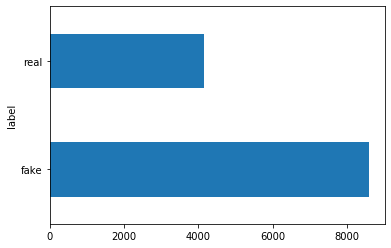

In [14]:
fltr_train_set['label'] = fltr_train_set['label'].replace('humor','fake')
fltr_train_set.groupby(['label']).size().plot.barh()

In [53]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, make_scorer
import seaborn as sn

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet

fltr_train_set['tweetTextToken'] = fltr_train_set['tweetText'].apply(word_tokenize)
fltr_train_set['tweetTextTokenPOS'] = fltr_train_set['tweetTextToken'].apply(pos_tag)

stop_words=set(stopwords.words("english"))
# print(stop_words)

def count(rowName):
    wordList = []
    for index, row in fltr_train_set.iterrows():
        for w in row[rowName]:
            wordList.append(w)
    fdist = FreqDist(wordList)
    print("feature:",len(fdist))
    print(fdist.most_common(40))
    fdist.plot(30,cumulative=False)
    return len(fdist)
    
def preprocessText(text):
    ps = PorterStemmer()
    filtered = []
    for w in text:
        if(w not in stop_words):
            filtered.append(ps.stem(w))
    return filtered

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''
    
def preprocessPOS(text):
    wl = WordNetLemmatizer()
    filtered = []
    for tuples in text:
        #print(tuples)
        w = tuples[0]
        pos = get_wordnet_pos(tuples[1])
        if(w not in stop_words and pos != ''):
            filtered.append(wl.lemmatize(w,pos=pos))
    return filtered

# for index, row in fltr_train_set.iterrows():
#     print(row['c1'], row['c2'])
fltr_train_set['tweetTextTokenNorm'] = fltr_train_set['tweetTextToken'].apply(preprocessText)
fltr_train_set['tweetTextTokenPOSNorm'] = fltr_train_set['tweetTextTokenPOS'].apply(preprocessPOS)
# f = count('tweetTextToken')
# fNorm = count('tweetTextTokenNorm')
# fPOSNorm = count('tweetTextTokenPOSNorm')
fltr_train_set['tweetTextTokenNorm']=fltr_train_set['tweetTextTokenNorm'].apply(lambda x: " ".join(x) )
fltr_train_set['tweetTextTokenPOSNorm']=fltr_train_set['tweetTextTokenPOSNorm'].apply(lambda x: " ".join(x) )

#fltr_train_set['tweetTextTokenPOSNorm'] = fltr_train_set['tweetTextTokenPOSNorm'].replace(regex=r'[.,\/#!$%\^&\*\"\'?@;:{}“=\-_`~()]',value='')

vectorizerPOSNorm = TfidfVectorizer(stop_words='english')
X = vectorizerPOSNorm.fit_transform(fltr_train_set['tweetTextTokenPOSNorm'])
y = fltr_train_set['label']

#add more features hasttag and memtion num and 2 more algorithms sym and (random forest or cnn)

posTest = fltr_test_set['tweetText'].apply(word_tokenize)
posTest = posTest.apply(pos_tag)
posTest = posTest.apply(preprocessPOS)
posTest = posTest.apply(lambda x: " ".join(x) )
X_test = vectorizerPOSNorm.transform(posTest)
y_test = fltr_test_set['label']

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7)
X = svd.fit_transform(vectorizerPOSNorm.transform(fltr_train_set['tweetTextTokenPOSNorm']))
X_test = svd.transform(vectorizerPOSNorm.transform(posTest))

print("feature:", len(vectorizerPOSNorm.get_feature_names()))

feature: 12106


In [126]:
from collections import Counter
X_resampled, y_resampled = SMOTE().fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

[('fake', 8579), ('real', 8579)]


In [17]:
def analysis(trueY,predY):
    print("Acc:",accuracy_score(trueY, predY))
    print()
    print("Fake Class score")
    print("Recall:",recall_score(trueY, predY, pos_label="fake"))
    print("Precison:",precision_score(trueY, predY, pos_label="fake"))
    print("F1-score:",f1_score(trueY, predY, pos_label="fake"))
    print()
    print("Real Class score")
    print("Recall:",recall_score(trueY, predY, pos_label="real"))
    print("Precison:",precision_score(trueY, predY, pos_label="real"))
    print("F1-score:",f1_score(trueY, predY, pos_label="real"))
    print()
    print("Confusion matrix")
    cm = confusion_matrix(trueY, predY)
    #print(cm)
    df_cm = pandas.DataFrame(cm, ["fake","real"], ["fake","real"])
    #plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size
    ax.set(xlabel='True Value', 
           ylabel='Predicted Value')

    plt.show()

Decision Tree Classifier
Acc: 0.6207723035952064

Fake Class score
Recall: 0.8963079340141398
Precison: 0.6629866356769321
F1-score: 0.7621910487641951

Real Class score
Recall: 0.04052936311000827
Precison: 0.15654952076677317
F1-score: 0.06438896189224705

Confusion matrix


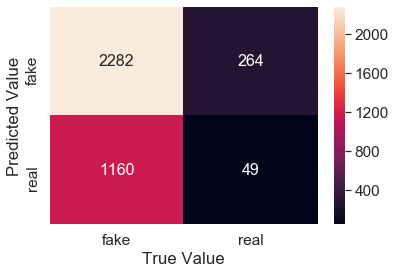

Bagging Classifier
Acc: 0.8498002663115846

Fake Class score
Recall: 0.9485467399842891
Precison: 0.8479634831460674
F1-score: 0.8954393770856507

Real Class score
Recall: 0.6418527708850289
Precison: 0.8555678059536935
F1-score: 0.7334593572778827

Confusion matrix


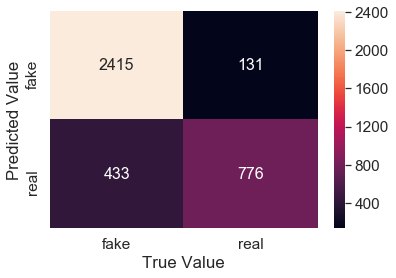

In [144]:
# # Solution (obtained by using GridSearch)
# from sklearn.model_selection import GridSearchCV

# param_grid = {'n_estimators': [2500,3000,4000]}
# bag_clf = BaggingClassifier(tree_clf, 
#                             bootstrap=True,
#                             max_samples=0.8,
#                             max_features=0.2,
#                             n_jobs=-1)
# grid_search = GridSearchCV(bag_clf, param_grid)
# grid_search.fit(X, y)
# print(grid_search.best_params_)
vectorizerPOSNorm = TfidfVectorizer(stop_words='english',max_features=12000)
X = vectorizerPOSNorm.fit_transform(fltr_train_set['tweetTextTokenPOSNorm'])
X_test = vectorizerPOSNorm.transform(posTest)

# from collections import Counter
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
# X_resampled, y_resampled = SMOTE().fit_sample(X, y)
# print(sorted(Counter(y_resampled).items()))

tree_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(tree_clf, 
                            n_estimators=150, 
                            max_samples=0.8,
                            max_features=0.2,
                            bootstrap=True)

# cv_results = cross_validate(bag_clf, X, y, cv=5)
# cv_results['test_score']


#fit the bagging classifier
tree_clf.fit(X, y)
bag_clf.fit(X, y)

y_pred_tree = tree_clf.predict(X_test)
y_pred_bag = bag_clf.predict(X_test)

print("Decision Tree Classifier")
analysis(y_test, y_pred_tree)

print("Bagging Classifier")
analysis(y_test, y_pred_bag)

Decision Tree Classifier
Acc: 0.7619174434087883

Fake Class score
Recall: 0.6692851531814611
Precison: 0.9703872437357631
F1-score: 0.7921896792189679

Real Class score
Recall: 0.956989247311828
Precison: 0.5787893946973487
F1-score: 0.7213216957605986

Confusion matrix


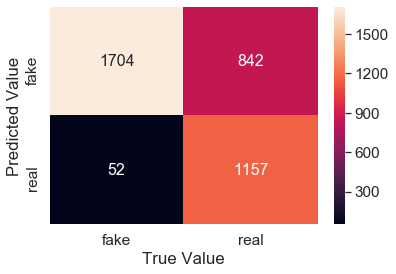

Bagging Classifier
Acc: 0.6087882822902796

Fake Class score
Recall: 0.5027494108405341
Precison: 0.8631153068105192
F1-score: 0.6353933978654752

Real Class score
Recall: 0.8320926385442514
Precison: 0.44278169014084506
F1-score: 0.5779948290721056

Confusion matrix


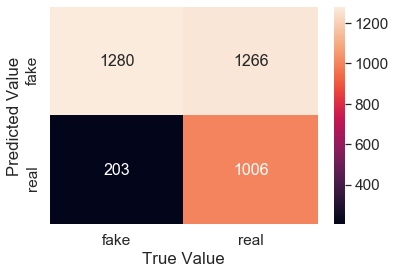

In [143]:
tree_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(tree_clf, 
                            n_estimators=300, 
                            max_samples=0.8,
                            max_features=0.2,
                            bootstrap=True)

# cv_results = cross_validate(bag_clf, X, y, cv=5)
# cv_results['test_score']

#fit the bagging classifier
tree_clf.fit(X_resampled, y_resampled)
bag_clf.fit(X_resampled, y_resampled)

y_pred_tree = tree_clf.predict(X_test)
y_pred_bag = bag_clf.predict(X_test)

print("Decision Tree Classifier")
analysis(y_test, y_pred_tree)

print("Bagging Classifier")
analysis(y_test, y_pred_bag)

[('fake', 8579), ('real', 8579)]


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Classifier
Acc: 0.8143808255659121

Fake Class score
Recall: 0.8711704634721131
Precison: 0.8573637417858523
F1-score: 0.8642119618157023

Real Class score
Recall: 0.6947890818858561
Precison: 0.7191780821917808
F1-score: 0.70677324358435

Confusion matrix


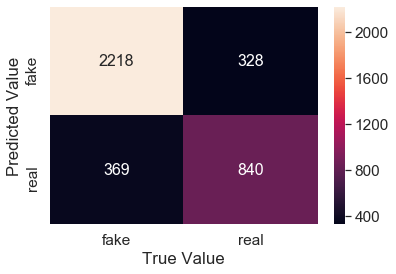

In [140]:
# # Solution (obtained by using GridSearch)
# from sklearn.model_selection import GridSearchCV

# param_grid = {'max_leaf_nodes':[200,250],'max_depth':[200,300]}
# rfc_clf = RandomForestClassifier(random_state=0, n_estimators=100, min_samples_leaf=5)
# grid_search = GridSearchCV(rfc_clf, param_grid, cv=5)
# grid_search.fit(X, y)
# print(grid_search.best_params_)
vectorizerPOSNorm = TfidfVectorizer(stop_words='english',max_features=8500)
X = vectorizerPOSNorm.fit_transform(fltr_train_set['tweetTextTokenPOSNorm'])
X_test = vectorizerPOSNorm.transform(posTest)

from collections import Counter
X_resampled, y_resampled = SMOTE().fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

rfc_clf = RandomForestClassifier()
rfc_clf.fit(X, y)

# cv_results = cross_validate(rfc_clf, X, y, cv=5)
# cv_results['test_score']

y_pred_rfc = rfc_clf.predict(X_test)
print("Random Forest Classifier")
analysis(y_test, y_pred_rfc)

Multinomial Naive Bayes Classifier
Acc: 0.8881491344873502

Fake Class score
Recall: 0.9611154752553024
Precison: 0.8840317919075145
F1-score: 0.9209634926608957

Real Class score
Recall: 0.7344913151364765
Precison: 0.8996960486322189
F1-score: 0.8087431693989071

Confusion matrix


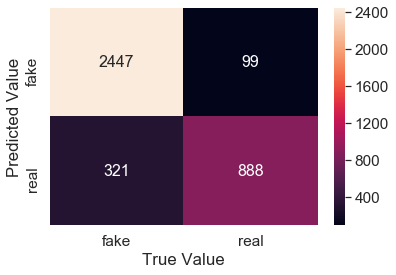

In [94]:
vectorizerPOSNorm = TfidfVectorizer(stop_words='english',max_features=3000)
X = vectorizerPOSNorm.fit_transform(fltr_train_set['tweetTextTokenPOSNorm'])
X_test = vectorizerPOSNorm.transform(posTest)
# # Solution (obtained by using GridSearch)
# from sklearn.model_selection import GridSearchCV

# param_grid = {'C': [0.5,1,2,3,4,5]}
# svm_clf = SVC(gamma='scale')
# grid_search = GridSearchCV(svm_clf, param_grid)
# grid_search.fit(X, y)
# print(grid_search.best_params_)

mnb_clf = MultinomialNB(alpha = 7.7)
mnb_clf.fit(X, y)

y_pred_mnb = mnb_clf.predict(X_test)

print("Multinomial Naive Bayes Classifier")
analysis(y_test, y_pred_mnb)

k-nearest Neighbors Classifier
Acc: 0.866577896138482

Fake Class score
Recall: 0.9732914375490966
Precison: 0.8512538646513226
F1-score: 0.9081913139087411

Real Class score
Recall: 0.6418527708850289
Precison: 0.919431279620853
F1-score: 0.7559668777398928

Confusion matrix


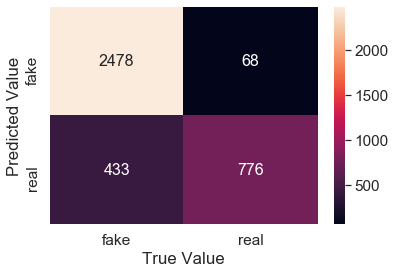

In [157]:
vectorizerPOSNorm = TfidfVectorizer(stop_words='english',max_features=12000)
X = vectorizerPOSNorm.fit_transform(fltr_train_set['tweetTextTokenPOSNorm'])
X_test = vectorizerPOSNorm.transform(posTest)
# # Solution (obtained by using GridSearch)
# from sklearn.model_selection import GridSearchCV

# param_grid = {'C': [0.5,1,2,3,4,5]}
# svm_clf = SVC(gamma='scale')
# grid_search = GridSearchCV(svm_clf, param_grid)
# grid_search.fit(X, y)
# print(grid_search.best_params_)

kn_clf = KNeighborsClassifier(n_neighbors=7)
kn_clf.fit(X, y)

y_pred_kn = kn_clf.predict(X_test)

print("k-nearest Neighbors Classifier")
analysis(y_test, y_pred_kn)

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarn

Logistic Classifier
Acc: 0.8692410119840213

Fake Class score
Recall: 0.9827179890023566
Precison: 0.8484231943031536
F1-score: 0.9106460418562329

Real Class score
Recall: 0.630272952853598
Precison: 0.9454094292803971
F1-score: 0.7563275434243175

Confusion matrix


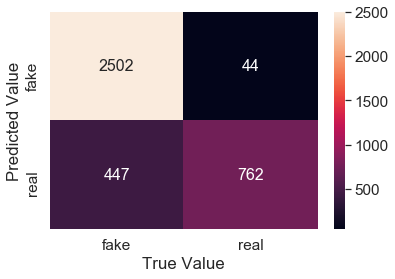

In [156]:
from sklearn.linear_model import LogisticRegressionCV
vectorizerPOSNorm = TfidfVectorizer(stop_words='english', max_features=12000)
X = vectorizerPOSNorm.fit_transform(fltr_train_set['tweetTextTokenPOSNorm'])
X_test = vectorizerPOSNorm.transform(posTest)
y = fltr_train_set['label']
y_test = fltr_test_set['label']

lg_clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y)

y_pred_lg = kn_clf.predict(X_test)

print("Logistic Classifier")
analysis(y_test, y_pred_lg)